In [2]:
#libs
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr, spearmanr
import gseapy
import matplotlib as mp
import matplotlib.patches as mpatches
import pybedtools
import importlib
# You need a working bedtools path rereload the lib (for pybedtools to work.)
pybedtools.set_bedtools_path('/path/to/bedtools/bin/')
pybedtools = importlib.reload(pybedtools)
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
def cleanGOdfs(dfList, dbList, top=3):
    cleanDFs = []
    for db in list( zip(dfList, dbList) ):
        tmpDF = db[0]
        # Sort by Pvalue (low to high) and Odds ratio (high to low.)
        tmpDF = tmpDF.sort_values(['Adjusted.P.value', 'Odds.Ratio'], ascending=[True, False])
        tmpDF['DB'] = str( db[1] )
        cleanDFs.append(tmpDF.head(top))
    cleandf = pd.concat(cleanDFs)
    cleandf['-log10(Padj)'] = -np.log10(cleandf['Adjusted.P.value'])
    return cleandf

def pointDens(x,y):
    xy = np.vstack( [x,y] )
    dens = gaussian_kde(xy)(xy)
    return dens

def Log2Series(series):
    return np.log2(series + 1).values

def hex2rgb(hexCol):
    hexCol = hexCol.replace('#','')
    hexLen = len(hexCol)
    return tuple ( int(hexCol[i:i + hexLen // 3], 16) for i in range(0, hexLen, hexLen // 3) )

def rgb2dec(tupe):
     return [v/256 for v in tupe]

    
def cmapFromHexLis(hexList):
    rgbLis = [rgb2dec( hex2rgb (i) ) for i in hexList ]
    cmp = mp.colors.LinearSegmentedColormap.from_list("CustomCol", rgbLis, N=256)
    return cmp

## Preprocessing

Trim reads for the transposase adapter [EBF_AL env]

```bash
cutadapt -j 20 --minimum-length 25 -A CTGTCTCTTATA -a CTGTCTCTTATA -o fq_cutadapt/${sample}_R1.fastq.gz -p fq_cutadapt/${sample}_R2.fastq.gz fq/${sample}_R1.fastq.gz fq/${sample}_R2.fastq.gz
```

run snakePipes DNA mapping [snakePipes env]

```bash
DNA-mapping --dedup --mapq 5 -j 10 -i fq_cutadapt -o ./snakePipes_mapq5_dedup mm10
```

run ATACofthesnake for differential accessibility [ATACofthesnake env]
The GTF file, blacklist, genome fasta and motifs.meme file can be found under the LFS directory (zenodo).

```bash
ATAC --bamDir
  bams/ --sampleSheet ss.tsv --blackList blacklist.bed --genes genes.gtf --genomeSize
  1.87e9 --genomeFasta genome.fa --condaPrefix /localenv/deboutte/anaconda/miniconda3/
  --fragSizeMax 1000 --motifs motifs.meme
```



## Heatmap - KO vs WT [EBF_AL env]

filtered bam files (snakePipes output) were merged with samtools and converted to normalized (RPKM) bigwig using: 

```bash
bamCoverage -b $bamfile.bam -o $bamfile.bw --bl ../../LFS/genomeData/blacklist.bed -bs 10 -p 20 --normalizeUsing RPKM --exactScaling
```

Compute Matrices: 

```bash

# MPP3 differential regions.

computeMatrix reference-point -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed -S ../../LFS/BigWig/MPP3_WT.rpkm.bw ../../LFS/BigWig/MPP3_KO.rpkm.bw -o ../../LFS/Matrices/MPP3diff_ATAC_3regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20

# MPP4 differential regions.

computeMatrix reference-point -R ../../data/ATAC/output/MPP4_WT.bed  ../../data/ATAC/output/MPP4_KO.bed -S ../../LFS/BigWig/MPP3_WT.rpkm.bw ../../LFS/BigWig/MPP3_KO.rpkm.bw -o ../../LFS/Matrices/MPP3diff_ATAC_4regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20
```
heatmaps:

```bash
plotHeatmap --matrixFile ../../LFS/Matrices/MPP3diff_ATAC_3regions.npz -o ../../figures/ATAC_MPP3diff_MPP3regions.svg --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP3 WT peaks (410)" "MPP3 KO peaks (49)" --samplesLabel "WT" "KO" --plotTitle "MPP3" --plotFileFormat 'svg' --colorList 'white, #E87B2A' --zMin 0 --zMax 150

plotHeatmap --matrixFile ../../LFS/Matrices/MPP3diff_ATAC_4regions.npz -o ../../figures/ATAC_MPP3diff_MPP4regions.svg --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP4 WT (103)" "MPP4 KO (182)" --samplesLabel "WT" "KO" --plotTitle "MPP4" --plotFileFormat 'svg' --colorList 'white, #1272BA' --zMin 0 --zMax 150
```

```bash
# MPP3 differential regions.

computeMatrix reference-point -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed -S ../../LFS/BigWig/MPP4_WT.rpkm.bw ../../LFS/BigWig/MPP4_KO.rpkm.bw -o ../../LFS/Matrices/MPP4diff_ATAC_3regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20

# MPP4 differential regions.

computeMatrix reference-point -R ../../data/ATAC/output/MPP4_WT.bed ../../data/ATAC/output/MPP4_KO.bed -S ../../LFS/BigWig/MPP4_WT.rpkm.bw ../../LFS/BigWig/MPP4_KO.rpkm.bw -o ../../LFS/Matrices/MPP4diff_ATAC_4regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20
```

```bash
plotHeatmap --matrixFile ../../LFS/Matrices/MPP4diff_ATAC_3regions.npz -o ../../figures/ATAC_MPP4diff_MPP3regions.svg --colorMap 'Blues' --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP3 WT peaks (410)" "MPP3 KO peaks (49)" --samplesLabel "WT" "KO" --plotTitle "MPP4" --plotFileFormat 'svg' --colorList 'white,#E87B2A' --zMin 0 --zMax 250

plotHeatmap --matrixFile ../../LFS/Matrices/MPP4diff_ATAC_4regions.npz -o ../../figures/ATAC_MPP4diff_MPP4regions.svg --colorMap 'Blues' --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP4 WT (103)" "MPP4 KO (182)" --samplesLabel "WT" "KO" --plotTitle "MPP4" --plotFileFormat 'svg' --colorList 'white,#1272BA' --zMin 0 --zMax 250

```

## Heatmap - MPP3 vs MPP4 [EBF_AL env]

```bash
computeMatrix reference-point -R ../../data/ATAC_mpp3vmpp4/output/MPP3.bed -S ../../LFS/BigWig/MPP3_WT.rpkm.bw ../../LFS/BigWig/MPP4_WT.rpkm.bw -o ../../LFS/Matrices/MPP3v4_MPP3spec_ATAC.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20
```

```bash
computeMatrix reference-point -R ../../data/ATAC_mpp3vmpp4/output/MPP4.bed -S ../../LFS/BigWig/MPP3_WT.rpkm.bw ../../LFS/BigWig/MPP4_WT.rpkm.bw -o ../../LFS/Matrices/MPP3v4_MPP4spec_ATAC.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20
```


```bash
plotHeatmap --matrixFile ../../LFS/Matrices/MPP3v4_MPP3spec_ATAC.npz -o ../../figures/supp/ATAC_MPP3vMPP4_MPP3spec.svg --colorList 'white,#E87B2A' --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP3 specific peaks (8950)" --samplesLabel "MPP3" "MPP4" --plotFileFormat 'svg'
```

```bash
plotHeatmap --matrixFile ../../LFS/Matrices/MPP3v4_MPP4spec_ATAC.npz -o ../../figures/supp/ATAC_MPP3vMPP4_MPP4spec.svg --colorList 'white,#1272BA' --whatToShow "heatmap and colorbar" --xAxisLabel "distance (bp)" --regionsLabel "MPP4 specific peaks (8069)" --samplesLabel "MPP3" "MPP4" --plotFileFormat 'svg'
```


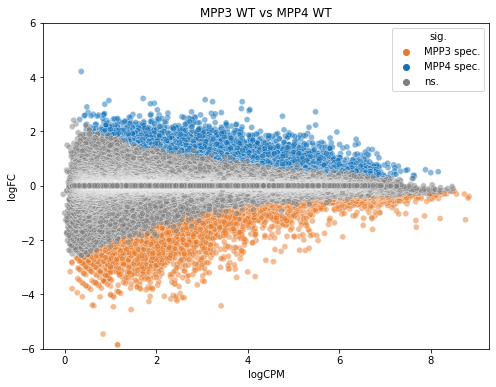

In [3]:
# [EBF_AL env]
## MA Plot 3v4

# MPP3WT = #E87B2A
# MPP4WT = #1272BA

ATAC_3v4 = pd.read_csv("../../data/ATAC_mpp3vmpp4/output/MPP3vMPP4_edgeR.tsv", sep='\t', index_col = 0)

ATAC_3v4['sig.'] = 'ns.'
ATAC_3v4['sig.'] = np.where((ATAC_3v4['FDR'] < 0.05) & (ATAC_3v4['logFC'] < 0), 'MPP3 spec.', ATAC_3v4['sig.'])
ATAC_3v4['sig.'] = np.where((ATAC_3v4['FDR'] < 0.05) & (ATAC_3v4['logFC'] > 0), 'MPP4 spec.', ATAC_3v4['sig.'])

plt.figure(figsize=(8,6))
g = sns.scatterplot(
    data=ATAC_3v4,
    x='logCPM',
    y='logFC',
    hue='sig.',
    alpha=0.5,
    # MPP3, MPP4, ns.
    palette= ['#E87B2A','#1272BA','#7f7f7f'],
    rasterized=True
).set_title('MPP3 WT vs MPP4 WT')
g.axes.set(ylim=(-6,6))
g.figure.savefig("../../figures/supp/MPP3vMPP4_MAplot.svg", dpi=300)

### genomeTracks [EBF_AL env]

configFiles and bed files per gene (Cd19 and Igll1) are prepared manually.
Note we also include some ChIPs (from the Public_ChIP notebook).

Tracks are plotted using:

Cd19:
```bash
pyGenomeTracks --region 7:126407353-126418217 --tracks ../../data/ATAC/output/tracks/cd19.ini --title Cd19 --outFileName ../../figures/Tracks_cd19.svg
```

Igll1:
```bash
pyGenomeTracks --region 16:16859398-16864879 --tracks ../../data/ATAC/output/tracks/Igll1.ini --title Igll1 --outFileName ../../figures/Tracks_Igll1.svg
```

### Correlations [EBF_AL env]

Correlation peak counts for replicates.


In [4]:
countMat = pd.read_csv('../../data/ATAC/output/countMatrix.tsv', sep='\t')
countMat.index = countMat[ ['chr','start','end'] ].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
del countMat['chr']
del countMat['start']
del countMat['end']
redCountMat =   (countMat
         .assign(sum=countMat.sum(axis=1))
         .sort_values(by='sum', ascending=False)
         .iloc[:, :-1]
         .head(10000) )
redCountMat.head()

,MPP3_WT1,MPP3_WT2,MPP3_KO1,MPP3_KO2,MPP4_WT1,MPP4_WT2,MPP4_KO1,MPP4_KO2
15_102405297_102406397,3771.0,4028.0,3486.0,1183.0,1671.0,2475.0,2233.0,2594.0
9_124422640_124424692,3351.0,3534.0,3311.0,1500.0,1770.0,2328.0,2025.0,2476.0
16_42874950_42876365,3462.0,3552.0,3063.0,1126.0,1586.0,2111.0,2288.0,2672.0
9_123461812_123462257,3303.0,4080.0,5084.0,1518.0,1124.0,1455.0,1528.0,1688.0
7_25267292_25268460,3034.0,3243.0,2808.0,957.0,1539.0,2082.0,1930.0,2061.0


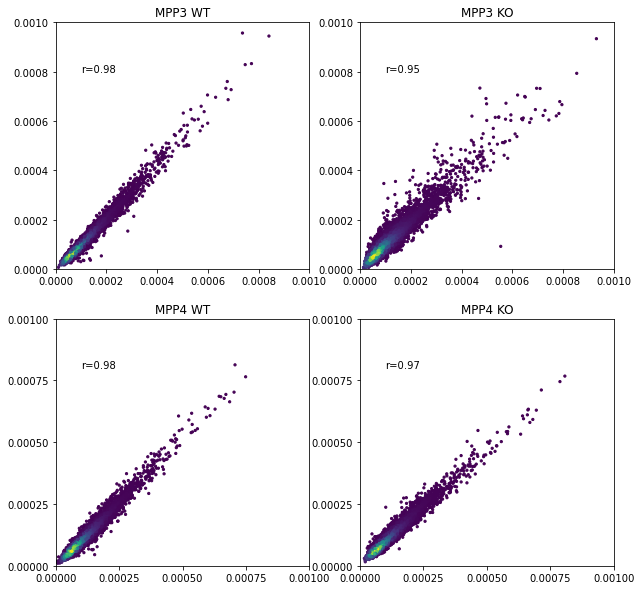

In [5]:
#[EBF_AL env]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# MPP3WT
x = redCountMat['MPP3_WT1'].div(redCountMat['MPP3_WT1'].sum())
y = redCountMat['MPP3_WT2'].div(redCountMat['MPP3_WT2'].sum())
ax[0,0].scatter(x,
           y,
           c = pointDens(x,y),
           s=5
          ).set_rasterized(True)
ax[0,0].text(0.0001,0.0008, "r=" + str(round( pearsonr(x, y)[0], 2)))
ax[0,0].set_xlim(0,0.001)
ax[0,0].set_ylim(0,0.001)
ax[0,0].locator_params(axis='y', nbins=5)
ax[0,0].locator_params(axis='x', nbins=5)
ax[0,0].set_title("MPP3 WT")

# MPP3KO
x = redCountMat['MPP3_KO1'].div(redCountMat['MPP3_KO1'].sum())
y = redCountMat['MPP3_KO2'].div(redCountMat['MPP3_KO2'].sum())
ax[0,1].scatter(x,
           y,
           c = pointDens(x,y),
           s=5
          ).set_rasterized(True)
ax[0,1].text(0.0001,0.0008, "r=" + str(round( pearsonr(x, y)[0], 2)))
ax[0,1].set_xlim(0,0.001)
ax[0,1].set_ylim(0,0.001)
ax[0,1].locator_params(axis='y', nbins=5)
ax[0,1].locator_params(axis='x', nbins=5)
ax[0,1].set_title("MPP3 KO")

# MPP4WT
x = redCountMat['MPP4_WT1'].div(redCountMat['MPP4_WT1'].sum())
y = redCountMat['MPP4_WT2'].div(redCountMat['MPP4_WT2'].sum())
ax[1,0].scatter(x,
           y,
           c = pointDens(x,y),
           s=5
          ).set_rasterized(True)
ax[1,0].text(0.0001,0.0008, "r=" + str(round( pearsonr(x, y)[0], 2)))
ax[1,0].set_xlim(0,0.001)
ax[1,0].set_ylim(0,0.001)
ax[1,0].set_title("MPP4 WT")
ax[1,0].locator_params(axis='y', nbins=4)
ax[1,0].locator_params(axis='x', nbins=4)

# MPP4KO
x = redCountMat['MPP4_KO1'].div(redCountMat['MPP4_KO1'].sum())
y = redCountMat['MPP4_KO2'].div(redCountMat['MPP4_KO2'].sum())
ax[1,1].scatter(x,
           y,
           c = pointDens(x,y),
           s=5
          ).set_rasterized(True)
ax[1,1].text(0.0001,0.0008, "r=" + str(round( pearsonr(x, y)[0], 2)))
ax[1,1].set_xlim(0,0.001)
ax[1,1].set_ylim(0,0.001)
ax[1,1].set_title("MPP4 KO")
ax[1,1].locator_params(axis='y', nbins=4)
ax[1,1].locator_params(axis='x', nbins=4)
plt.savefig('../../figures/supp/ATACcount_correlation.svg', dpi=300)

In [40]:
# GSEA [EBF_AL env]

# Create custom geneSets for:

# CLP and GMP specific gene sets:
CLPvGMP = pd.read_csv('../../data/RNA/CLPvGMP.tsv', sep='\t')
CLPvGMP['gene_symbol'] = CLPvGMP.index

# Take 100 genes with lowest padjusted.
CLPvGMPsort = CLPvGMP.sort_values(by=['padj'])
CLPgenes = list(CLPvGMPsort[(CLPvGMPsort['padj'] < 0.05) & (CLPvGMPsort['log2FoldChange'] > 2)]['gene_symbol'].head(300))
GMPgenes = list(CLPvGMPsort[(CLPvGMPsort['padj'] < 0.05) & (CLPvGMPsort['log2FoldChange'] < -2)]['gene_symbol'].head(300))

# Set up a dict
genesetDic = {
    'CLP' : CLPgenes,
    'GMP' : GMPgenes,
}
print(len(genesetDic['CLP']))
print(len(genesetDic['GMP']))

300
300


In [58]:
## GSEA for ATAC: MPP3 [EBF_AL env]

# Get a list of enhancers (made in ChIP notebook w/ CRUP).
# Probability cutoff = 0.8
MPP3enh = []
with open('../../data/ChIP/CRUP/MPP3_enh.bed') as f:
    for line in f:
        MPP3enh.append( '_'.join( line.strip().split() ) )

# Read ATAC dataframes
MPP3_WTvKO_ATAC = pd.read_csv("../../data/ATAC/output/MPP3_KOvsWT_edgeR.tsv", sep='\t', index_col=0)
# subset for enhancers.
MPP3_WTvKO_ATAC = MPP3_WTvKO_ATAC[MPP3_WTvKO_ATAC.index.isin(MPP3enh)]
MPP3_WTvKO_ATAC = MPP3_WTvKO_ATAC[ ['logFC', 'FDR', 'gene_name'] ]
MPP3_WTvKO_ATAC.dropna(subset = ["gene_name"], inplace=True)
#create abs val
MPP3_WTvKO_ATAC['absLFC'] = abs(MPP3_WTvKO_ATAC['logFC'])
MPP3_WTvKO_ATAC = MPP3_WTvKO_ATAC.sort_values('absLFC', ascending=True).drop_duplicates('gene_name', keep='last').sort_index()

# Create rank to use in GSEA:
MPP3_WTvKO_ATAC['Rank'] =  -np.log10(MPP3_WTvKO_ATAC['FDR']) * MPP3_WTvKO_ATAC['logFC']
MPP3_WTvKO_ATAC = MPP3_WTvKO_ATAC.sort_values("Rank", ascending=False)
MPP3_WTvKO_ATAC = MPP3_WTvKO_ATAC[ ['gene_name', 'Rank'] ]

# Run GSEA
MPP3GSEAres = gseapy.prerank(MPP3_WTvKO_ATAC, genesetDic, outdir='../../data/ATAC/GSEA/MPP3enh',
                pheno_pos='KO',pheno_neg='WT', processes=5, permutation_num=1000)
MPP3GSEAres.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
GMP,0.586196,1.393612,0.000000,0.000000,300,161,Csf2ra;Card9;Kcnip3;Prtn3;Rnf217;Mapkapk3;Fam1...,Csf2ra;Card9;Kcnip3;Prtn3;Rnf217;Mapkapk3;Fam1...
CLP,-0.842411,-1.195903,0.016016,0.023583,300,220,Paqr5;Ccdc88c;Nfatc2;Sik1;Egr1;Zfp36;Prkch;Dus...,Lsp1;Lrmp;Rnf122;Sema4d;Mef2c;Prr5;Mta3;Nfkbie...


In [55]:
## GSEA for ATAC: MPP4 [EBF_AL env]

# Get a list of enhancers (made in ChIP notebook w/ CRUP).
# Probability cutoff = 0.8
MPP4enh = []
with open('../../data/ChIP/CRUP/MPP4_enh.bed') as f:
    for line in f:
        MPP4enh.append( '_'.join( line.strip().split() ) )

# Read ATAC dataframes
MPP4_WTvKO_ATAC = pd.read_csv("../../data/ATAC/output/MPP4_KOvsWT_edgeR.tsv", sep='\t', index_col=0)
# subset for enhancers.
MPP4_WTvKO_ATAC = MPP4_WTvKO_ATAC[MPP4_WTvKO_ATAC.index.isin(MPP4enh)]
MPP4_WTvKO_ATAC = MPP4_WTvKO_ATAC[ ['logFC', 'FDR', 'gene_name'] ]
MPP4_WTvKO_ATAC.dropna(subset = ["gene_name"], inplace=True)
#create abs val
MPP4_WTvKO_ATAC['absLFC'] = abs(MPP4_WTvKO_ATAC['logFC'])
MPP4_WTvKO_ATAC = MPP4_WTvKO_ATAC.sort_values('absLFC', ascending=True).drop_duplicates('gene_name', keep='last').sort_index()

# Create rank to use in GSEA:
MPP4_WTvKO_ATAC['Rank'] =  -np.log10(MPP4_WTvKO_ATAC['FDR']) * MPP4_WTvKO_ATAC['logFC']
MPP4_WTvKO_ATAC = MPP4_WTvKO_ATAC.sort_values("Rank", ascending=False)
MPP4_WTvKO_ATAC = MPP4_WTvKO_ATAC[ ['gene_name', 'Rank'] ]

# Run GSEA
MPP4GSEAres = gseapy.prerank(MPP4_WTvKO_ATAC, genesetDic, outdir='../../data/ATAC/GSEA/MPP4enh',
                pheno_pos='KO',pheno_neg='WT', processes=5, permutation_num=1000)
MPP4GSEAres.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
GMP,0.481747,1.176697,0.179340,0.162774,300,155,Hsd11b1;Dram1;Prss57;Cldn15;Selp;Gpx3;Rab44;Mp...,Hsd11b1;Dram1;Prss57;Cldn15;Selp;Gpx3;Rab44;Mp...
CLP,0.480531,1.216330,0.111441,0.239416,300,218,Med13l;Vav2;Ebf1;Bin1;Ppfia4;Zdhhc8;Ccnd3;Mef2...,Med13l;Vav2;Ebf1;Bin1;Ppfia4;Zdhhc8;Ccnd3;Mef2...


In [43]:
# Plot GSEA [EBF_AL env]

# MPP3
gseapy.plot.gseaplot(rank_metric=MPP3GSEAres.ranking,
                     term=MPP3GSEAres.res2d.index[0],
                     **MPP3GSEAres.results[MPP3GSEAres.res2d.index[0]],
                     ofname='../../figures/MPP3gsea_GMP.svg',
                    pheno_pos='Ebf1 KO',
                    pheno_neg='Ebf1 WT')
gseapy.plot.gseaplot(rank_metric=MPP3GSEAres.ranking,
                     term=MPP3GSEAres.res2d.index[1],
                     **MPP3GSEAres.results[MPP3GSEAres.res2d.index[1]],
                     ofname='../../figures/MPP3gsea_CLP.svg',
                    pheno_pos='Ebf1 KO',
                    pheno_neg='Ebf1 WT')

# MPP4
gseapy.plot.gseaplot(rank_metric=MPP4GSEAres.ranking,
                     term=MPP4GSEAres.res2d.index[0],
                     **MPP4GSEAres.results[MPP4GSEAres.res2d.index[0]],
                     ofname='../../figures/MPP4gsea_CLP.svg',
                    pheno_pos='Ebf1 KO',
                    pheno_neg='Ebf1 WT')
gseapy.plot.gseaplot(rank_metric=MPP4GSEAres.ranking,
                     term=MPP4GSEAres.res2d.index[1],
                     **MPP4GSEAres.results[MPP4GSEAres.res2d.index[1]],
                     ofname='../../figures/MPP4gsea_GMP.svg',
                    pheno_pos='Ebf1 KO',
                    pheno_neg='Ebf1 WT')

### GO [GO env]

Run GO (using clusterProfiler in R). 
Database used: 'BP' (Biological processes)

```bash
cd ../scripts
conda activate GOenv
Rscript GO.R
cd ../books
```

Outputs are written under ../../data/ATAC/GO/\*tsv and ../../data/ATAC_mpp3vmpp4/GO/\*tsv



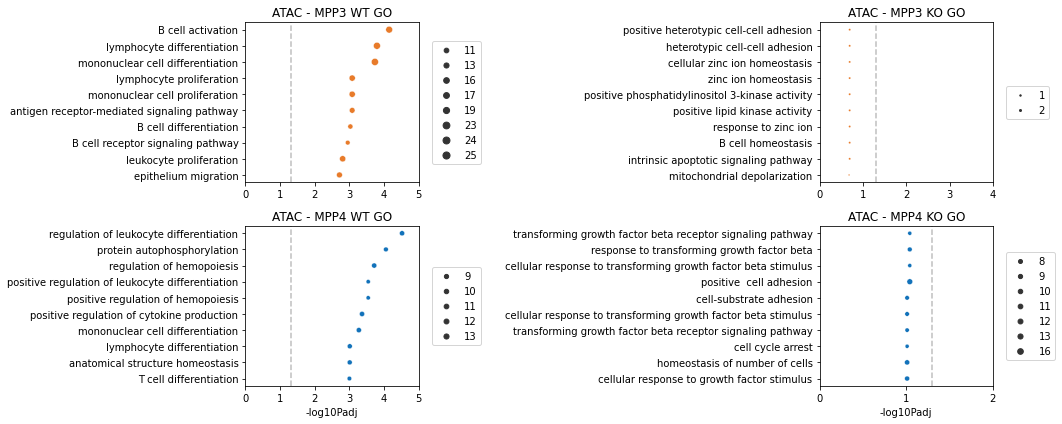

In [3]:
# GOplot for genes associated with MPP3 WT peaks. [EBF_AL env]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
sizeDic = {}
for i in range(0,31,1):
    sizeDic[i] = i*2
# MPP3WT - GO
MPP3WT_GO = pd.read_csv("../../data/ATAC/GO/WT_MPP3_GO.tsv", sep='\t')
MPP3WT_GO = MPP3WT_GO.sort_values(by='p.adjust', ascending=True)
MPP3WT_GO = MPP3WT_GO.head(10)
MPP3WT_GO['-log10Padj'] = -np.log10(MPP3WT_GO['p.adjust'])
g = sns.scatterplot(data=MPP3WT_GO, x='-log10Padj',
                    y='Description',
                    size=MPP3WT_GO['Count'],
                    color='#E87B2A',
                    ax=ax[0,0],
                    sizes=sizeDic
                   )
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylabel("")
ax[0,0].set_xlabel("")
ax[0,0].axvline(-np.log10(0.05), 0,10, linestyle='--', c='#7f7f7f', alpha=0.5)
ax[0,0].title.set_text("ATAC - MPP3 WT GO")
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

# MPP3KO - GO
MPP3KO_GO = pd.read_csv("../../data/ATAC/GO/KO_MPP3_GO.tsv", sep='\t')
MPP3KO_GO = MPP3KO_GO.sort_values(by='p.adjust', ascending=True)
MPP3KO_GO = MPP3KO_GO.head(10)
MPP3KO_GO['Description'] = MPP3KO_GO['Description'].map(lambda x: x.replace('regulation of ', ''))
MPP3KO_GO['Description'] = MPP3KO_GO['Description'].map(lambda x: x.replace(' in response to DNA damage', ''))
MPP3KO_GO['-log10Padj'] = -np.log10(MPP3KO_GO['p.adjust'])
g = sns.scatterplot(data=MPP3KO_GO, x='-log10Padj',
                    y='Description',
                    size=MPP3KO_GO['Count'],
                    color = '#E87B2A',
                    ax=ax[0,1],
                    sizes=sizeDic
                   )
ax[0,1].set_xlim(0,4)
ax[0,1].set_xticks([0,1,2,3,4])
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("")
ax[0,1].axvline(-np.log10(0.05), 0,10, linestyle='--', c='#7f7f7f', alpha=0.5)
ax[0,1].title.set_text("ATAC - MPP3 KO GO")
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

# MPP4WT - GO
MPP4WT_GO = pd.read_csv("../../data/ATAC/GO/WT_MPP4_GO.tsv", sep='\t')
MPP4WT_GO = MPP4WT_GO.sort_values(by='p.adjust', ascending=True)
MPP4WT_GO = MPP4WT_GO.head(10)
MPP4WT_GO['-log10Padj'] = -np.log10(MPP4WT_GO['p.adjust'])
g = sns.scatterplot(data=MPP4WT_GO, x='-log10Padj',
                    y='Description',
                    size=MPP4WT_GO['Count'],
                    color = '#1272BA',
                    ax=ax[1,0],
                    sizes=sizeDic
                   )
ax[1,0].set_xlim(0,5)
ax[1,0].set_ylabel("")
ax[1,0].axvline(-np.log10(0.05), 0,10, linestyle='--', c='#7f7f7f', alpha=0.5)
ax[1,0].title.set_text("ATAC - MPP4 WT GO")
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)



# MPP4KO - GO
MPP4KO_GO = pd.read_csv("../../data/ATAC/GO/KO_MPP4_GO.tsv", sep='\t')
MPP4KO_GO = MPP4KO_GO.sort_values(by='p.adjust', ascending=True)
MPP4KO_GO = MPP4KO_GO.head(10)
MPP4KO_GO['-log10Padj'] = -np.log10(MPP4KO_GO['p.adjust'])
MPP4KO_GO['Description'] = MPP4KO_GO['Description'].map(lambda x: x.replace('regulation of', ''))
g = sns.scatterplot(data=MPP4KO_GO, x='-log10Padj',
                    y='Description',
                    size=MPP4KO_GO['Count'],
                    ax=ax[1,1],
                    color = '#1272BA',
                    alpha=1,
                    sizes=sizeDic
                   )
ax[1,1].set_xlim(0,2)
ax[1,1].set_xticks([0,1,2])
ax[1,1].set_ylabel("")
ax[1,1].axvline(-np.log10(0.05), 0,10, linestyle='--', c='#7f7f7f', alpha=0.5)
ax[1,1].title.set_text("ATAC - MPP4 KO GO")
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.savefig("../../figures/GO_ATAC.svg", dpi=300)

In [65]:
# Correlation of MPP3 WT vs KO & CLP vs GMP [EBF_AL env]

ATAC_MPP3 = pd.read_csv("../../data/ATAC/output/MPP3_KOvsWT_edgeR.tsv", sep='\t', index_col=0)
ATAC_MPP3_red = ATAC_MPP3[ ['gene_name', 'logFC', 'FDR'] ]
ATAC_MPP3_red = ATAC_MPP3_red[ATAC_MPP3_red['gene_name'] != '']

# TSS
ATAC_MPP3_red_peaks = [ tuple(peak.split('_')) for peak in ATAC_MPP3_red.index]
ATAC_MPP3_red_peaks = pybedtools.BedTool(ATAC_MPP3_red_peaks)
TSS = pybedtools.BedTool('../../LFS/genomeData/TSS.bed')
ATAC_MPP3_red_TSS = ATAC_MPP3_red_peaks.intersect(TSS, wa=True).sort().merge()
ATAC_MPP3_red_TSS = ATAC_MPP3_red_TSS.to_dataframe()
ATAC_MPP3_red_TSS = list(ATAC_MPP3_red_TSS.apply( lambda row: '_'.join(row.values.astype(str)), axis=1 ) )

# RNA - CLPvGMP
RNA_CLPvGMP = pd.read_csv("../../data/RNA/CLPvGMP.tsv", sep='\t', index_col = 0)
RNA_CLPvGMP_red = RNA_CLPvGMP[['log2FoldChange','padj']]
RNA_CLPvGMP_red.index.name = 'gene_name'
RNA_CLPvGMP_red.reset_index(inplace=True)

# RNA - MPP3WT vs MPP3KO

RNA_3KOv3WT = pd.read_csv('../../data/RNA/MPP3_KOvsWT.tsv', sep='\t', index_col = 0)
RNA_3KOv3WT_red = RNA_3KOv3WT[['log2FoldChange', 'padj']]
RNA_3KOv3WT_red.index.name = 'gene_name'
RNA_3KOv3WT_red.reset_index(inplace=True)

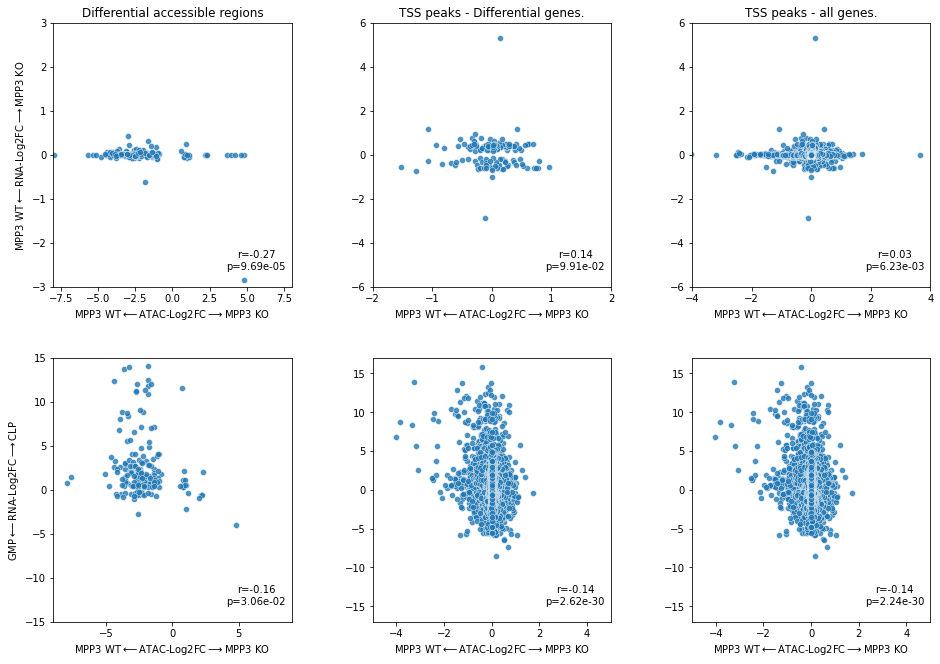

In [66]:
# Plot correlation.

ATAC_RNA_MPP3 = pd.merge(ATAC_MPP3_red,
                    RNA_3KOv3WT_red,
                   on='gene_name', how='inner')
ATAC_RNA_MPP3_sigPeak = ATAC_RNA_MPP3[ATAC_RNA_MPP3['FDR'] < 0.05].dropna()

ATAC_RNA_MPP3 = pd.merge(ATAC_MPP3_red[ATAC_MPP3_red.index.isin(ATAC_MPP3_red_TSS)],
                    RNA_3KOv3WT_red,
                   on='gene_name', how='inner')
ATAC_RNA_MPP3_allGene = ATAC_RNA_MPP3
ATAC_RNA_MPP3_sigGene = ATAC_RNA_MPP3[ATAC_RNA_MPP3['padj'] < 0.05].dropna()


ATAC_RNA_CLPGMP = pd.merge(ATAC_MPP3_red,
                    RNA_CLPvGMP_red,
                   on='gene_name', how='inner')
ATAC_RNA_CLPGMP_sigPeak = ATAC_RNA_CLPGMP[ATAC_RNA_CLPGMP['FDR'] < 0.05].dropna()

ATAC_RNA_CLPGMP = pd.merge(ATAC_MPP3_red[ATAC_MPP3_red.index.isin(ATAC_MPP3_red_TSS)],
                    RNA_CLPvGMP_red,
                   on='gene_name', how='inner')
ATAC_RNA_CLPGMP_allGene = ATAC_RNA_CLPGMP
ATAC_RNA_CLPGMP_sigGene = ATAC_RNA_CLPGMP[ATAC_RNA_CLPGMP['padj'] < 0.05]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
plt.tight_layout(pad=5.0)

# Correlation differential peaks - Genes: MPP3 WT vs MPP3 KO
sns.scatterplot(data=ATAC_RNA_MPP3_sigPeak, x='logFC', y='log2FoldChange', ax=ax[0,0],
            alpha=0.8, rasterized=True)
ax[0,0].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP3_sigPeak['log2FoldChange'],
                                              ATAC_RNA_MPP3_sigPeak['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3_sigPeak['log2FoldChange'],
                                     ATAC_RNA_MPP3_sigPeak['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,0].transAxes
          )
ax[0,0].set_title("Differential accessible regions")
ax[0,0].set_xlim(-8,8)
ax[0,0].set_ylim(-3,3)
ax[0,0].set_ylabel("MPP3 WT" + r'$\longleftarrow$' + "RNA-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")
ax[0,0].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")

# Correlation TSS - Genes: MPP3 WT vs MPP3 KO

sns.scatterplot(data=ATAC_RNA_MPP3_sigGene, x='logFC', y='log2FoldChange', ax=ax[0,1],
            alpha=0.8, rasterized=True)
ax[0,1].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP3_sigGene['log2FoldChange'],
                                              ATAC_RNA_MPP3_sigGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3_sigGene['log2FoldChange'],
                                     ATAC_RNA_MPP3_sigGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,1].transAxes
          )
ax[0,1].set_title("TSS peaks - Differential genes.")
ax[0,1].set_xlim(-2,2)
ax[0,1].set_ylim(-6,6)
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")

# Correlation TSS - allGenes: MPP3 WT vs MPP3 KO

sns.scatterplot(data=ATAC_RNA_MPP3_allGene, x='logFC', y='log2FoldChange', ax=ax[0,2],
            alpha=0.8, rasterized=True)
ax[0,2].text(0.85,0.1,"r=" + str(round( pearsonr(ATAC_RNA_MPP3_allGene['log2FoldChange'],
                                              ATAC_RNA_MPP3_allGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3_allGene['log2FoldChange'],
                                     ATAC_RNA_MPP3_allGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,2].transAxes
          )
ax[0,2].set_title("TSS peaks - all genes.")
ax[0,2].set_xlim(-4,4)
ax[0,2].set_ylim(-6,6)
ax[0,2].set_ylabel("")
ax[0,2].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")

##############################################################################################################
# Correlation differential peaks - Genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_sigPeak, x='logFC', y='log2FoldChange', ax=ax[1,0],
            alpha=0.8, rasterized=True)
ax[1,0].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_sigPeak['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_sigPeak['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_sigPeak['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_sigPeak['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,0].transAxes
          )
ax[1,0].set_xlim(-9,9)
ax[1,0].set_ylim(-15,15)
ax[1,0].set_ylabel("GMP" + r'$\longleftarrow$' + "RNA-Log2FC" + r'$\longrightarrow$' + "CLP")
ax[1,0].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")

# Correlation TSS peaks - Differential genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_sigGene, x='logFC', y='log2FoldChange', ax=ax[1,1],
            alpha=0.8, rasterized=True)
ax[1,1].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_sigGene['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_sigGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_sigGene['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_sigGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,1].transAxes
          )
ax[1,1].set_xlim(-5,5)
ax[1,1].set_ylim(-17,17)
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")

# Correlation TSS peaks - Differential genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_allGene, x='logFC', y='log2FoldChange', ax=ax[1,2],
            alpha=0.8, rasterized=True)
ax[1,2].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_allGene['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_allGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_allGene['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_allGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,2].transAxes
          )
ax[1,2].set_xlim(-5,5)
ax[1,2].set_ylim(-17,17)
ax[1,2].set_ylabel("")
ax[1,2].set_xlabel("MPP3 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP3 KO")
plt.savefig( "../../figures/ATAC_RNA_correlation_3WTvKO.svg", dpi=300 )

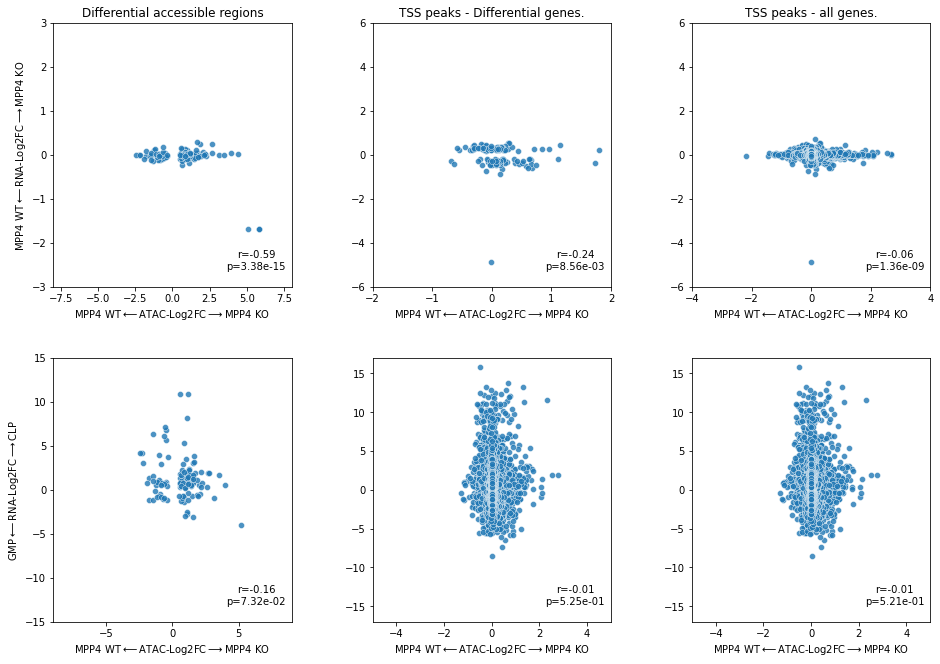

In [17]:
# Correlation of MPP4 WT vs KO & CLP vs GMP [EBF_AL env]

ATAC_MPP4 = pd.read_csv("../../data/ATAC/output/MPP4_KOvsWT_edgeR.tsv", sep='\t', index_col=0)
ATAC_MPP4_red = ATAC_MPP4[ ['gene_name', 'logFC', 'FDR'] ]
ATAC_MPP4_red = ATAC_MPP4_red[ATAC_MPP4_red['gene_name'] != '']

# TSS
ATAC_MPP4_red_peaks = [ tuple(peak.split('_')) for peak in ATAC_MPP4_red.index]
ATAC_MPP4_red_peaks = pybedtools.BedTool(ATAC_MPP4_red_peaks)
TSS = pybedtools.BedTool('../../LFS/genomeData/TSS.bed')
ATAC_MPP4_red_TSS = ATAC_MPP4_red_peaks.intersect(TSS, wa=True).sort().merge()
ATAC_MPP4_red_TSS = ATAC_MPP4_red_TSS.to_dataframe()
ATAC_MPP4_red_TSS = list(ATAC_MPP4_red_TSS.apply( lambda row: '_'.join(row.values.astype(str)), axis=1 ) )

# RNA - CLPvGMP
RNA_CLPvGMP = pd.read_csv("../../data/RNA/CLPvGMP.tsv", sep='\t', index_col = 0)
RNA_CLPvGMP_red = RNA_CLPvGMP[['log2FoldChange','padj']]
RNA_CLPvGMP_red.index.name = 'gene_name'
RNA_CLPvGMP_red.reset_index(inplace=True)

# RNA - MPP4WT vs MPP4KO

RNA_4KOv4WT = pd.read_csv('../../data/RNA/MPP4_KOvsWT.tsv', sep='\t', index_col = 0)
RNA_4KOv4WT_red = RNA_4KOv4WT[['log2FoldChange', 'padj']]
RNA_4KOv4WT_red.index.name = 'gene_name'
RNA_4KOv4WT_red.reset_index(inplace=True)


# Plot correlation.

ATAC_RNA_MPP4 = pd.merge(ATAC_MPP4_red,
                    RNA_4KOv4WT_red,
                   on='gene_name', how='inner')
ATAC_RNA_MPP4_sigPeak = ATAC_RNA_MPP4[ATAC_RNA_MPP4['FDR'] < 0.05].dropna()

ATAC_RNA_MPP4 = pd.merge(ATAC_MPP4_red[ATAC_MPP4_red.index.isin(ATAC_MPP4_red_TSS)],
                    RNA_4KOv4WT_red,
                   on='gene_name', how='inner')
ATAC_RNA_MPP4_allGene = ATAC_RNA_MPP4
ATAC_RNA_MPP4_sigGene = ATAC_RNA_MPP4[ATAC_RNA_MPP4['padj'] < 0.05].dropna()


ATAC_RNA_CLPGMP = pd.merge(ATAC_MPP4_red,
                    RNA_CLPvGMP_red,
                   on='gene_name', how='inner')
ATAC_RNA_CLPGMP_sigPeak = ATAC_RNA_CLPGMP[ATAC_RNA_CLPGMP['FDR'] < 0.05].dropna()

ATAC_RNA_CLPGMP = pd.merge(ATAC_MPP4_red[ATAC_MPP4_red.index.isin(ATAC_MPP4_red_TSS)],
                    RNA_CLPvGMP_red,
                   on='gene_name', how='inner')
ATAC_RNA_CLPGMP_allGene = ATAC_RNA_CLPGMP
ATAC_RNA_CLPGMP_sigGene = ATAC_RNA_CLPGMP[ATAC_RNA_CLPGMP['padj'] < 0.05]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
plt.tight_layout(pad=5.0)

# Correlation differential peaks - Genes: MPP4 WT vs MPP4 KO
sns.scatterplot(data=ATAC_RNA_MPP4_sigPeak, x='logFC', y='log2FoldChange', ax=ax[0,0],
            alpha=0.8, rasterized=True)
ax[0,0].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP4_sigPeak['log2FoldChange'],
                                              ATAC_RNA_MPP4_sigPeak['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP4_sigPeak['log2FoldChange'],
                                     ATAC_RNA_MPP4_sigPeak['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,0].transAxes
          )
ax[0,0].set_title("Differential accessible regions")
ax[0,0].set_xlim(-8,8)
ax[0,0].set_ylim(-3,3)
ax[0,0].set_ylabel("MPP4 WT" + r'$\longleftarrow$' + "RNA-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")
ax[0,0].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")

# Correlation TSS - Genes: MPP4 WT vs MPP4 KO

sns.scatterplot(data=ATAC_RNA_MPP4_sigGene, x='logFC', y='log2FoldChange', ax=ax[0,1],
            alpha=0.8, rasterized=True)
ax[0,1].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP4_sigGene['log2FoldChange'],
                                              ATAC_RNA_MPP4_sigGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP4_sigGene['log2FoldChange'],
                                     ATAC_RNA_MPP4_sigGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,1].transAxes
          )
ax[0,1].set_title("TSS peaks - Differential genes.")
ax[0,1].set_xlim(-2,2)
ax[0,1].set_ylim(-6,6)
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")

# Correlation TSS - allGenes: MPP4 WT vs MPP4 KO

sns.scatterplot(data=ATAC_RNA_MPP4_allGene, x='logFC', y='log2FoldChange', ax=ax[0,2],
            alpha=0.8, rasterized=True)
ax[0,2].text(0.85,0.1,"r=" + str(round( pearsonr(ATAC_RNA_MPP4_allGene['log2FoldChange'],
                                              ATAC_RNA_MPP4_allGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP4_allGene['log2FoldChange'],
                                     ATAC_RNA_MPP4_allGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0,2].transAxes
          )
ax[0,2].set_title("TSS peaks - all genes.")
ax[0,2].set_xlim(-4,4)
ax[0,2].set_ylim(-6,6)
ax[0,2].set_ylabel("")
ax[0,2].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")

##############################################################################################################
# Correlation differential peaks - Genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_sigPeak, x='logFC', y='log2FoldChange', ax=ax[1,0],
            alpha=0.8, rasterized=True)
ax[1,0].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_sigPeak['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_sigPeak['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_sigPeak['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_sigPeak['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,0].transAxes
          )
ax[1,0].set_xlim(-9,9)
ax[1,0].set_ylim(-15,15)
ax[1,0].set_ylabel("GMP" + r'$\longleftarrow$' + "RNA-Log2FC" + r'$\longrightarrow$' + "CLP")
ax[1,0].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")

# Correlation TSS peaks - Differential genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_sigGene, x='logFC', y='log2FoldChange', ax=ax[1,1],
            alpha=0.8, rasterized=True)
ax[1,1].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_sigGene['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_sigGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_sigGene['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_sigGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,1].transAxes
          )
ax[1,1].set_xlim(-5,5)
ax[1,1].set_ylim(-17,17)
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")

# Correlation TSS peaks - Differential genes: CLP v GMP
sns.scatterplot(data=ATAC_RNA_CLPGMP_allGene, x='logFC', y='log2FoldChange', ax=ax[1,2],
            alpha=0.8, rasterized=True)
ax[1,2].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_CLPGMP_allGene['log2FoldChange'],
                                              ATAC_RNA_CLPGMP_allGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_CLPGMP_allGene['log2FoldChange'],
                                     ATAC_RNA_CLPGMP_allGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1,2].transAxes
          )
ax[1,2].set_xlim(-5,5)
ax[1,2].set_ylim(-17,17)
ax[1,2].set_ylabel("")
ax[1,2].set_xlabel("MPP4 WT" + r'$\longleftarrow$' + "ATAC-Log2FC" + r'$\longrightarrow$' + "MPP4 KO")
plt.savefig( "../../figures/ATAC_RNA_correlation_4WTvKO.svg", dpi=300 )

In [18]:
# MPP3 vs MPP4 - ATAC&RNA. [EBF_AL env]

ATAC_3v4 = pd.read_csv("../../data/ATAC_mpp3vmpp4/output/MPP3vMPP4_edgeR.tsv", sep='\t', index_col=0)
ATAC_3v4_red = ATAC_3v4[['logFC','gene_name', 'FDR']]
ATAC_3v4_red = ATAC_3v4_red[ATAC_3v4_red['gene_name'] != '']
ATAC_3v4_red_peaks = [ tuple(peak.split('_')) for peak in ATAC_3v4_red.index]
ATAC_3v4_red_peaks = pybedtools.BedTool(ATAC_3v4_red_peaks)

# TSS
TSS = pybedtools.BedTool('../../LFS/genomeData/TSS.bed')
ATAC_3v4_red_TSS = ATAC_3v4_red_peaks.intersect(TSS, wa=True).sort().merge()
ATAC_3v4_red_TSS = ATAC_3v4_red_TSS.to_dataframe()
ATAC_3v4_red_TSS = list(ATAC_3v4_red_TSS.apply( lambda row: '_'.join(row.values.astype(str)), axis=1 ) )

#RNA
RNA_3v4 = pd.read_csv("../../data/RNA/WT_MPP4vMPP3.tsv", sep='\t', index_col = 0)
RNA_3v4_red = RNA_3v4[['log2FoldChange','padj']]
RNA_3v4_red.index.name = 'gene_name'
RNA_3v4_red.reset_index(inplace=True)

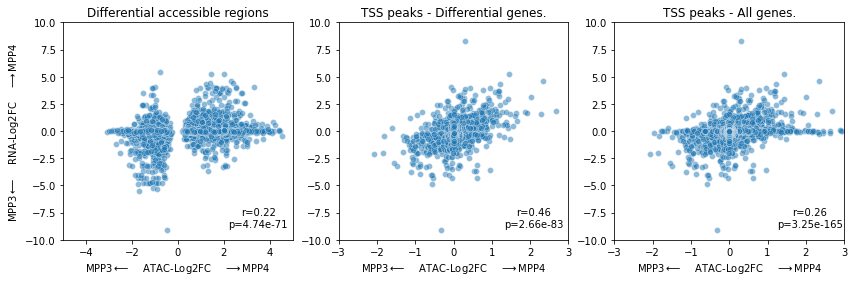

In [19]:
# [EBF_AL env]
ATAC_RNA_MPP3vMPP4 = pd.merge(ATAC_3v4_red,
                    RNA_3v4_red,
                   on='gene_name', how='inner')
# for ATAC: upregulated = MPP4, downregulated = MPP3
# for RNA: upregulated = MPP3, downregulated = MPP4
ATAC_RNA_MPP3vMPP4['logFC'] = -ATAC_RNA_MPP3vMPP4['logFC']
ATAC_RNA_MPP3vMPP4_sigPeak = ATAC_RNA_MPP3vMPP4[ATAC_RNA_MPP3vMPP4['FDR'] < 0.05].dropna()

ATAC_RNA_MPP3vMPP4 = pd.merge(ATAC_3v4_red[ATAC_3v4_red.index.isin(ATAC_3v4_red_TSS)],
                    RNA_3v4_red,
                   on='gene_name', how='inner')
ATAC_RNA_MPP3vMPP4['logFC'] = -ATAC_RNA_MPP3vMPP4['logFC']
ATAC_RNA_MPP3vMPP4_allGene = ATAC_RNA_MPP3vMPP4
ATAC_RNA_MPP3vMPP4_sigGene = ATAC_RNA_MPP3vMPP4[ATAC_RNA_MPP3vMPP4['padj'] < 0.05].dropna()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

sns.scatterplot(data=ATAC_RNA_MPP3vMPP4_sigPeak, x='logFC', y='log2FoldChange',
            ax=ax[0], alpha=0.5, rasterized=True)
ax[0].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP3vMPP4_sigPeak['log2FoldChange'],
                                              ATAC_RNA_MPP3vMPP4_sigPeak['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3vMPP4_sigPeak['log2FoldChange'],
                                     ATAC_RNA_MPP3vMPP4_sigPeak['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[0].transAxes
          )

ax[0].set_title("Differential accessible regions")
ax[0].set_xlim(-5,5)
ax[0].set_ylim(-10,10)
ax[0].set_ylabel("MPP3" + r'$\longleftarrow$' + "    RNA-Log2FC    " + r'$\longrightarrow$' + "MPP4")
ax[0].set_xlabel("MPP3" + r'$\longleftarrow$' + "    ATAC-Log2FC    " + r'$\longrightarrow$' + "MPP4")

# Differential genes.
sns.scatterplot(data=ATAC_RNA_MPP3vMPP4_sigGene, x='logFC', y='log2FoldChange',
            ax=ax[1], alpha=0.5, rasterized=True)
ax[1].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP3vMPP4_sigGene['log2FoldChange'],
                                              ATAC_RNA_MPP3vMPP4_sigGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3vMPP4_sigGene['log2FoldChange'],
                                     ATAC_RNA_MPP3vMPP4_sigGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[1].transAxes
          )

ax[1].set_title("Differential accessible regions")
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-10,10)
ax[1].set_ylabel("")
ax[1].set_title("TSS peaks - Differential genes.")
ax[1].set_xlabel("MPP3" + r'$\longleftarrow$' + "    ATAC-Log2FC    " + r'$\longrightarrow$' + "MPP4")

# All genes.

sns.scatterplot(data=ATAC_RNA_MPP3vMPP4_allGene, x='logFC', y='log2FoldChange',
            ax=ax[2], alpha=0.5, rasterized=True)
ax[2].text(0.85,0.1, "r=" + str(round( pearsonr(ATAC_RNA_MPP3vMPP4_allGene['log2FoldChange'],
                                              ATAC_RNA_MPP3vMPP4_allGene['logFC'])[0], 2)) + "\n" +
           "p=" + '{:0.2e}'.format(pearsonr(ATAC_RNA_MPP3vMPP4_allGene['log2FoldChange'],
                                     ATAC_RNA_MPP3vMPP4_allGene['logFC'])[1], 2),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[2].transAxes
          )

ax[2].set_xlim(-3,3)
ax[2].set_ylim(-10,10)
ax[2].set_ylabel("")
ax[2].set_title("TSS peaks - All genes.")
ax[2].set_xlabel("MPP3" + r'$\longleftarrow$' + "    ATAC-Log2FC    " + r'$\longrightarrow$' + "MPP4")


plt.savefig("../../figures/supp/CorATACRNA_3v4.svg", dpi=300)